In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import inspect

currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
srcdir = parentdir + '/src'
os.sys.path.insert(1, srcdir)

import numpy as np
import copy
import time
import pybullet as p
import pybullet_data
import pinocchio as se3
import matplotlib
import tsid
import numpy.matlib as matlib
from numpy import nan
from numpy.linalg import norm as norm
import commands

import matplotlib.pyplot as plt
from pinbullet_wrapper import PinBulletWrapper
from pinocchio.robot_wrapper import RobotWrapper
from pinocchio.utils import zero
from romeo_foot import RomeoFoot

from dotmap import DotMap
import pickle

In [2]:
font = {'family' : 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3, linewidth=200, suppress=True)

In [3]:
BMODE = p.GUI
LOGGING = True
LOCAL = True

STEP_DURATION = 800
N_STEPS = 6
N_SIMULATION = N_STEPS * STEP_DURATION
DOUBLE_SUPPORT_DURATION = 5

DELAY = 4
NS3 = True
SCENARIO = 'building'
IDX = 5

DELAY_START = 0
ONBOARD_WINDOW = 50

PRELANDING = 10
PRELIFTING = 10

ONBOARD_FREQ = 5

In [4]:
# compute delayed indices
DELAYED_IDX = []

if NS3:
    ns3_path = parentdir + '/data/ns3/' + SCENARIO + '/delayed_idx/'
    DELAYED_IDX = np.load(ns3_path + str(IDX) +'.npy')
    
else:
    for i in range(N_SIMULATION):
        if i >= DELAY_START:
            delayed_idx = np.maximum(i-DELAY, DELAY_START)
        else:
            delayed_idx = i
        DELAYED_IDX.append(delayed_idx)
        
DELAYED_IDX_RAW = copy.copy(DELAYED_IDX)

In [5]:
Com = np.load(parentdir+'/data/com.npy')
foot_steps = np.load(parentdir+'/data/foot_steps.npy')
left_foot_steps = foot_steps[1::2]
right_foot_steps = foot_steps[0::2]

In [6]:
mu = 0.5                            # friction coefficient
rf_frame_name = "RAnkleRoll"        # right foot frame name
lf_frame_name = "LAnkleRoll"        # left foot frame name

w_com = 1.0                     # weight of center of mass task
w_posture = 1e-3                # weight of joint posture task
w_forceRef = 1e-5               # weight of force regularization task
w_foot_motion = 1.0

kp_contact = 10.0               # proportional gain of contact constraint
kd_contact = 7.0
kp_com = 10.0                   # proportional gain of center of mass task
kp_posture = 50.0               # proportional gain of joint posture task
kp_foot_motion = 30.0
kd_foot_motion = 1000.0

sigma_q = 0
sigma_v = 0 # measurement noise

In [7]:
path = parentdir + '/models/romeo'
robot_urdf = path + '/urdf/romeo.urdf'
plane_urdf = parentdir + '/models/plane.urdf'
vector = se3.StdVec_StdString()
vector.extend(item for item in path)
robot = tsid.RobotWrapper(robot_urdf, vector, se3.JointModelFreeFlyer(), False)
pinocchio_robot = se3.buildModelFromUrdf(robot_urdf, se3.JointModelFreeFlyer())

In [8]:
physicsClient = p.connect(BMODE)#or p.DIRECT for non-graphical version
dt = 1./1000.
p.setTimeStep(dt)
p.setGravity(0,0,-9.81)
robot_id = p.loadURDF(robot_urdf,[0,0,0])
plane_id = p.loadURDF(plane_urdf,[0,0,-0.88], useFixedBase=1)

In [9]:
joint_names = [n for n in robot.model().names]
del joint_names[0]
del joint_names[0]
endeff_names = ["l_sole", "r_sole"]
pbwrapper = PinBulletWrapper(robot_id, pinocchio_robot, joint_names, endeff_names)

In [10]:
p.changeDynamics(plane_id, -1, restitution=0.99,
                 lateralFriction=1.0, spinningFriction=1.0, rollingFriction=1.0,
                 contactStiffness=1e6, contactDamping=2e3)
p.resetJointState(robot_id, 20, np.pi/2)
p.resetJointState(robot_id, 27, np.pi/2)

In [11]:
q, v = pbwrapper.get_state()
assert robot.model().existFrame(rf_frame_name)
assert robot.model().existFrame(lf_frame_name)

In [12]:
t = 0.

invdyn = tsid.InverseDynamicsFormulationAccForce("tsid", robot, False)
invdyn.computeProblemData(t, q, v)
data = invdyn.data()

comTask = tsid.TaskComEquality("task-com", robot)
comTask.setKp(kp_com * np.matrix(np.ones(3)).transpose())
comTask.setKd(2.0 * np.sqrt(kp_com) * np.matrix(np.ones(3)).transpose())
invdyn.addMotionTask(comTask, w_com, 1, 0.0)

postureTask = tsid.TaskJointPosture("task-posture", robot)
postureTask.setKp(kp_posture * np.matrix(np.ones(robot.nv-6)).transpose())
postureTask.setKd(2.0 * np.sqrt(kp_posture) * np.matrix(np.ones(robot.nv-6)).transpose())
invdyn.addMotionTask(postureTask, w_posture, 1, 0.0)

com_ref = Com[0,0].reshape((-1,1))
trajCom = tsid.TrajectoryEuclidianConstant("traj_com", com_ref)

q_ref = q[7:].copy()
q_ref[3] = np.pi/4
q_ref[9] = np.pi/4
q_ref[2] = -np.pi/6
q_ref[8] = -np.pi/6

trajPosture = tsid.TrajectoryEuclidianConstant("traj_joint", q_ref)

solver = tsid.SolverHQuadProgFast("qp solver")
solver.resize(invdyn.nVar, invdyn.nEq, invdyn.nIn)

In [13]:
left_foot = RomeoFoot(lf_frame_name, invdyn, robot)
right_foot = RomeoFoot(rf_frame_name, invdyn, robot)

left_foot.add_contact_task(kp=kp_contact, kd=kd_contact, w_forceRef=w_forceRef, mu=mu)
right_foot.add_contact_task(kp=kp_contact, kd=kd_contact, w_forceRef=w_forceRef, mu=mu)

left_foot.add_foot_steps(left_foot_steps)
right_foot.add_foot_steps(right_foot_steps)

In [15]:
## move to the initial configuration
for i in range(2000):
    
    sampleCom = trajCom.computeNext()
    comTask.setReference(sampleCom)
    samplePosture = trajPosture.computeNext()
    postureTask.setReference(samplePosture)
    HQPData = invdyn.computeProblemData(t, q, v)
    
    sol = solver.solve(HQPData)
    tau = invdyn.getActuatorForces(sol)
              
    # bullet
    pbwrapper.send_joint_command(tau)    
    p.stepSimulation()
    q, v = pbwrapper.get_state()
    t += dt
    
Com[:,0,2] = robot.com(invdyn.data())[2]

In [16]:
left_foot.add_motion_task(kp=kp_foot_motion, kd=kd_foot_motion, w=w_foot_motion)
right_foot.add_motion_task(kp=kp_foot_motion, kd=kd_foot_motion, w=w_foot_motion)

In [17]:
feet = [left_foot, right_foot]
left_foot.lift()
left_foot.take_the_next_step()
right_foot.take_the_next_step()

swing_foot_idx = 0
support_foot_idx = 1

landing = STEP_DURATION
last_landing = STEP_DURATION
lifting = landing + DOUBLE_SUPPORT_DURATION
last_lifting = last_landing + DOUBLE_SUPPORT_DURATION

In [19]:
LOG = []
SOL = []
step = 0
success = True

for i in range(N_SIMULATION):
    
    data = DotMap()
    LOG.append(data)
    
    swing_foot = feet[swing_foot_idx]
    support_foot = feet[support_foot_idx]
    
    # precompute solution for landing
    if LOCAL and i == landing - PRELANDING:
        swing_foot.land(precomputing=True)
        HQPData = invdyn.computeProblemData(t, q + noise_q, v + noise_v)
        sol_landing = solver.solve(HQPData)
        swing_foot.lift(precomputing=True)
        
    # precompute solution for lifting        
    if LOCAL and i ==  lifting - PRELIFTING:
        swing_foot.land(precomputing=True)
        support_foot.lift(precomputing=True)
        HQPData = invdyn.computeProblemData(t, q + noise_q, v + noise_v)
        sol_lifting = solver.solve(HQPData)
        swing_foot.lift(precomputing=True)
        support_foot.land(precomputing=True)    
            
    if i == landing:
        swing_foot.land()
        
    if i == lifting:
        last_landing = landing
        last_lifting = lifting
        landing += STEP_DURATION
        lifting += STEP_DURATION
        support_foot.lift()
        support_foot.take_the_next_step()
        swing_foot_idx, support_foot_idx = support_foot_idx, swing_foot_idx
        
    right_foot.update(dt)
    left_foot.update(dt)
        
    sampleCom = trajCom.computeNext()
    sampleCom.pos(Com[i,0].reshape(-1, 1))
    sampleCom.vel(Com[i,1].reshape(-1, 1))
    sampleCom.acc(Com[i,2].reshape(-1, 1))
    samplePosture = trajPosture.computeNext()
    postureTask.setReference(samplePosture)
    comTask.setReference(sampleCom)
    
    noise_q = sigma_q * np.matrix(np.random.randn(q.shape[0])).T
    noise_q[:7] = 0
    noise_v = sigma_v * np.matrix(np.random.randn(v.shape[0])).T
    noise_v[:6] = 0
    
    fullqp_start = time.time()
    HQPData = invdyn.computeProblemData(t, q + noise_q, v + noise_v)
    sol_fullqp = solver.solve(HQPData)
    
    data.fullqp_time = time.time() - fullqp_start
    data.q = q + noise_q
    data.v = v + noise_v
    data.noise_q = noise_q
    data.noise_v = noise_v
    
    if(sol.status != 0):
        print "QP problem could not be solved! Error code:", sol.status
        success = False
        break
        
    SOL.append(sol_fullqp)
    tau = invdyn.getActuatorForces(sol_fullqp)
    dv = invdyn.getAccelerations(sol_fullqp)
    
    if(np.linalg.norm(dv[:6]) >= 1e3):
        print "Slipped and fell."
        success = False
        break
        
    data.tau_fullqp = tau
    data.dv_fullqp = dv
    data.activeset_fullqp = sol.activeSet
    
    # Perform onboard computation around contact switches
    if LOCAL and step * STEP_DURATION - ONBOARD_WINDOW <= i < step * STEP_DURATION + ONBOARD_WINDOW:
        # when on-board, only compute full qp every ONBOARD_FREQ ms
        if i % ONBOARD_FREQ == 0:
            delay = 2 + int(1000 * data.fullqp_time)
            # 2 ms extra delay for local controller (<= 1ms)
            # and one-time pre-computation spread out over the whole window (possible with multithreading)
            for h in range(ONBOARD_FREQ):
                # check if this delay < network delay
                if h < delay:
                    DELAYED_IDX[i + h] = np.maximum(DELAYED_IDX[i + h], i - ONBOARD_FREQ)
                if h >= delay:
                    DELAYED_IDX[i + h] = np.maximum(DELAYED_IDX[i + h], i)                
                
    delayed_idx = DELAYED_IDX[i]
    data.delay = i - delayed_idx
               
    if i == step * STEP_DURATION + ONBOARD_WINDOW:
        step += 1

    delayed_data = LOG[delayed_idx]
    delayed_sol = SOL[delayed_idx]
    
    if LOCAL and landing <= i < lifting and delayed_idx < landing:
        delayed_sol = sol_landing
    
    if LOCAL and last_lifting <= i and delayed_idx < last_lifting:
        delayed_sol = sol_lifting
    
    if LOCAL:
        local_start = time.time()
        HQPData = invdyn.computeProblemData(t, q + noise_q, v + noise_v)
        sol = solver.solve_local(HQPData, delayed_sol)
        data.local_time = time.time() - local_start
        tau = invdyn.getActuatorForces(sol)
        dv = invdyn.getAccelerations(sol)
    else: 
        solver.compute_slack(HQPData, delayed_sol)
        sol = delayed_sol
        tau = delayed_data.tau_fullqp
        dv = delayed_data.dv_fullqp
        
    data.slack = sol.slack
    data.tau = tau
    data.dv = dv
    data.activeset = sol.activeSet
    
    # data logging from noiseless measurements
    HQPData = invdyn.computeProblemData(t, q, v)
    data.com.pos = robot.com(invdyn.data())
    data.com.pos_ref = sampleCom.pos()
    data.left_foot.pos = left_foot.pos(t,q,v).translation
    data.left_foot.pos_ref = left_foot.motion_ref.pos()[:3]
    data.right_foot.pos = right_foot.pos(t,q,v).translation
    data.right_foot.pos_ref = right_foot.motion_ref.pos()[:3]
    
    ## pinocchio
    #v_mean = v + 0.5*dt*dv
    #v += dt*dv
    #q = se3.integrate(robot.model(), q, dt*v_mean)
    #pbwrapper.reset_state(q, v)
    #p.stepSimulation()
    #t += dt

Slipped and fell.


In [20]:
p.disconnect()
print "Simulation completed"

Simulation completed


In [22]:
exp_data = DotMap()
file_name = 'walk_'
data_path = parentdir + '/data/'
exp_data.success = success

if NS3:
    exp_data.scenario = SCENARIO
    file_name = file_name + SCENARIO + str(IDX)
    data_path += 'ns3/exp_data/'
else:
    exp_data.delay = DELAY
    exp_data.delay_start = DELAY_START
    file_name += str(DELAY)
    data_path += 'const/exp_data/'
    
exp_data.local = LOCAL

if LOCAL:
    file_name += '_local'
exp_data.log = LOG

#if LOGGING:
#    with open(data_path + file_name + '.pkl', 'wb') as f:
#        pickle.dump(exp_data, f, pickle.HIGHEST_PROTOCOL)

TypeError: unsupported operand type(s) for -: 'DotMap' and 'DotMap'

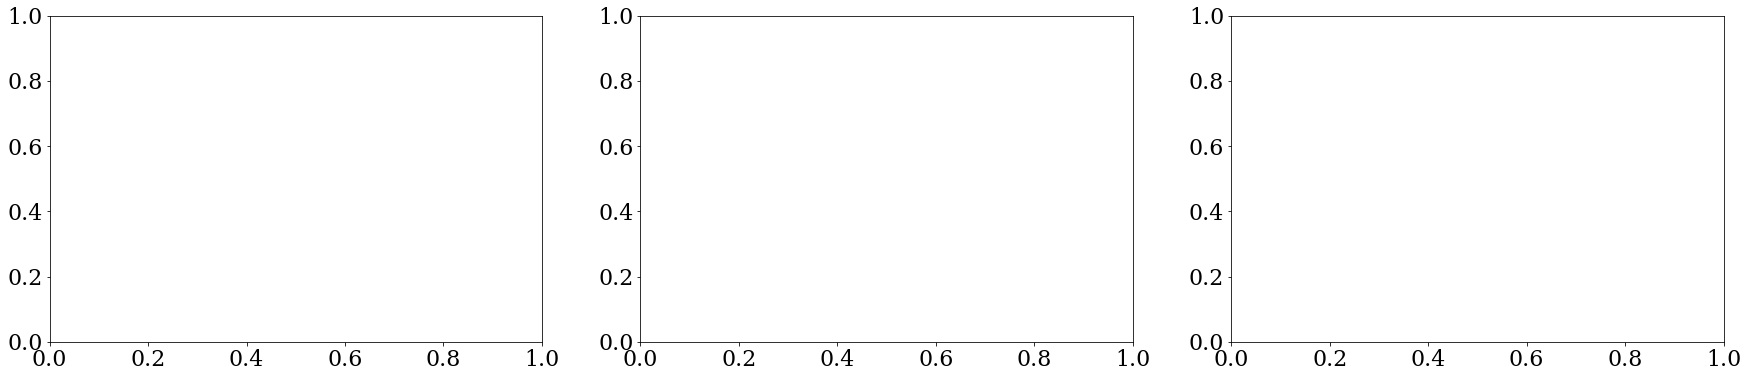

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(30, 6))
time = np.arange(0.0, N_SIMULATION*dt, dt)
axes = ['x', 'y', 'z']
for i in range(3):
    err = 100*np.abs([data.com.pos[i]-data.com.pos_ref[i] for data in LOG])
    ax[0].plot(time, err, lw=4, label='CoM '+axes[i])
    
ax[0].grid()
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('CoM tracking error' + ' [cm]' )
_ = ax[0].legend(loc='upper left', ncol=1, fancybox=True, shadow=True)
ax[0].set_ylim([0, 10])

slack = [data.slack[1] for data in LOG]
ax[1].plot(time, slack, lw=1)
ax[1].grid()
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Constraint violation' )
# ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# ax[1].set_ylim([0, 20])

delays = [data.delay for data in LOG]
ax[2].grid()
ax[2].set_xlabel('Time [s]')
ax[2].set_ylabel('Delay [ms]' )           
ax[2].plot(time, delays, lw=1, color='k')
ax[2].set_ylim([0, 180])


for s in range(N_STEPS + 1):
    lb = ONBOARD_WINDOW
    ub = ONBOARD_WINDOW
    if s == 0:
        lb = 0
    if s == N_STEPS:
        ub = 0
    ax[2].axvspan(1e-3*(s * STEP_DURATION - lb), 
                  1e-3*(s * STEP_DURATION + ub), 
                  alpha=0.5, color='green',
                  label="_"*s + "Full QP solved onboard")
    _ = ax[2].legend(loc='upper left', fancybox=True, shadow=True)

file_name = 'walk_err_'
if NS3:
    file_name += SCENARIO
    file_name += str(IDX)
if LOCAL:
    file_name += '_local'
    
plot_path = parentdir + '/data/plots/'
fig.savefig(plot_path + file_name + '.png', bbox_inches='tight')

In [ ]:
# print np.mean([1000*data.fullqp_time for data in LOG])
# print np.mean([1000*data.local_time for data in LOG])
# print np.max([1000*data.fullqp_time for data in LOG])
# print np.max([1000*data.local_time for data in LOG])

In [ ]:
# M = 100
# com_diff = [[] for m in range(M)]
# slack = M * [[] for m in range(M)]
# K = set()

# for i in range(N_SIMULATION):
#     error = DotMap()

#     activeset_cached = LOG[i].activeset
#     activeset_true = LOG[i].activeset_fullqp
#     activeset_cached = set(np.array(activeset_cached).flatten())
#     activeset_true = set(np.array(activeset_true).flatten())
    
#     k = len(activeset_cached - activeset_true)
#     K.add(k)
#     com_diff[k].append(np.linalg.norm(LOG[i].com.pos[:,0]-LOG[i].com.pos_ref[:,0]))
#     slack[k].append(LOG[i].slack)
